In [2]:
# import modules
import importlib
from pypet import Environment, Parameter, cartesian_product, progressbar, Trajectory
import numpy as np
import csv
import os
import copy
import pickle
import logging
from datetime import date
import matplotlib.pyplot as plt
plt.style.use('seaborn-talk')
import scipy
from fitnessinference import simulation as simu
from fitnessinference import analysis as ana

In [7]:
# run this to reload a module after editing it 
# (instead of restarting the whole notebook kernel):
importlib.reload(ana)

<module 'fitnessinference.analysis' from 'C:\\Users\\julia\\Documents\\Resources\\InfluenzaFitnessLandscape\\NewApproachFromMarch2021\\InfluenzaFitnessInference\\code\\notebooks\\fitnessinference\\analysis.py'>

In [30]:
# # simulation params, which should be stored
# # at initialization of simulation in the simulation folder


# simu_dict = {}

# simu_name = '2021Apr07'

# result_directory = ('C:/Users/julia/Documents/Resources/InfluenzaFitnessLandscape/NewApproachFromMarch2021/'
#                     'InfluenzaFitnessInference')
# result_directory = os.path.normpath(result_directory)
# simu_code_file = 'simulation.py'
# simu_code_filepath = os.path.join(result_directory, 'code', 'notebooks', 'fitnessinference', simu_code_file)

# simu_comment = 'simulation with varying population size'

# varied_simu_params = ['N_pop']

# simu_param_dict = dict(N_pop = 10**2,
#                        N_site = 20,
#                        N_state = 2,
#                        mu = 10**(-4),
#                        sigma_h = 1,
#                        D0 = 5,
#                        h_0 = -7,
#                        J_0 = 0,
#                        hJ_coeffs = 'p24',
#                        seed = 123456,
#                        N_simu = 200 
#                       )

# exp_dict = {'N_pop' : [10, 100, 10**3, 10**4, 10**5, 10**6]}

# for key, val in exp_dict.items():
#     num_runs = len(val)
#     break
# run_list = np.arange(num_runs).tolist()

# # for later simus, simply call run_name = 'run_' + str(i) for run number i
# run_names = {}
# for i in range(len(exp_dict['N_pop'])):
#     if exp_dict['N_pop'][i] == 10:
#         params = 'N_pop_10N_site_20N_state_2mu_1e-04sigma_h_1D0_5h_0_-7J_0_0seed_123456N_simu_2e+02'
#     else:
#         params = ('N_pop_%.eN_site_%.iN_state_%.imu_%.esigma_h_%.iD0_%.ih_0_%.iJ_0_%.iseed_%.iN_simu_%.e' % (exp_dict['N_pop'][i], 
#                                                                                                                  simu_param_dict['N_site'], 
#                                                                                                                  simu_param_dict['N_state'], 
#                                                                                                                  simu_param_dict['mu'], 
#                                                                                                                  simu_param_dict['sigma_h'], 
#                                                                                                                  simu_param_dict['D0'], 
#                                                                                                                  simu_param_dict['h_0'], 
#                                                                                                                  simu_param_dict['J_0'], 
#                                                                                                                  simu_param_dict['seed'], 
#                                                                                                                  simu_param_dict['N_simu']))
#     run_name = 'running_' + params
#     run_names[i] = run_name

# # store the various params, which describe the simu, in a dictionary
# simu_dict['simu_name'] = simu_name
# simu_dict['simu_code_filepath'] = simu_code_filepath
# simu_dict['simu_comment'] = simu_comment
# simu_dict['varied_simu_params'] = varied_simu_params
# simu_dict['simu_param_dict'] = simu_param_dict
# simu_dict['exp_dict'] = exp_dict
# simu_dict['run_list'] = run_list
# simu_dict['run_names'] = run_names

# simu_info_filename = 'simu_info.data'
# temp_folder = os.path.join(result_directory, 'results', 'simulations', simu_name + '_temp')
# simu_info_filepath = os.path.join(temp_folder, simu_info_filename)
# with open(simu_info_filepath, 'wb') as f:
#     pickle.dump(simu_dict, f)

In [9]:
# # run analyses and save results for individual anas plus collected params/data

# # set sampling and  default inference parameters
# simu_name = '2021Apr07'

# # initialize dictionary for saving collected analysis params and results
# ana_dict={}

# # folder and file paths (save with date of analysis)
# today = date.today()
# strdate_today = today.strftime("%Y%b%d")
# analysis_name = "analysis_" + strdate_today
# result_directory = ('C:/Users/julia/Documents/Resources/InfluenzaFitnessLandscape/NewApproachFromMarch2021/'
#                     'InfluenzaFitnessInference')
# result_directory = os.path.normpath(result_directory)
# temp_folder = os.path.join(result_directory, 'results', 'simulations', simu_name + '_temp')
# analysis_info_path = os.path.join(temp_folder, analysis_name + '.data')
# while os.path.exists(analysis_info_path):
#     # for each new analysis on the same day, add 'i' to file_name
#     # to not overwrite files
#     analysis_name = analysis_name + 'i'
#     analysis_info_path = os.path.join(temp_folder, analysis_name + '.data')    

# ana_code_file = 'flu_sequence_analysis.ipynb'
# ana_code_filepath = os.path.join(os.getcwd(), ana_code_file)

# ana_param_dict ={'seed': 20390, 
#                'B': 10**3, 
#                'inf_start': 100, 
#                'inf_end': 200, 
#                'lambda_h': 0, 
#                'lambda_J': 1, 
#                'lambda_f': 0
#           }

# varied_ana_params = ['B']

# # lists of equal lengths to define param combos
# exp_ana_dict = {'B': [10, 100, 10**3, 10**4, 10**5]}
# exp_ana_dict = cartesian_product(exp_ana_dict)

# ana_comment = 'analysis with various sampling sizes'

# # load simulation info file
# simu_info_filename = 'simu_info.data'
# simu_info_filepath = os.path.join(temp_folder, simu_info_filename)
# with open(simu_info_filepath, 'rb') as f:
#     simu_dict = pickle.load(f)

# # dictionary with params varied during simulation
# exp_dict = simu_dict['exp_dict']
# # list of run numbers
# run_list = simu_dict['run_list']
# # list of file names for each run (without extension)
# run_names = simu_dict['run_names']
    
# # calculate number of analyses per simulation
# # and create ana_list
# for key, val in exp_ana_dict.items():
#     num_anas = len(val)
#     break
# ana_list = np.arange(num_anas).tolist()

# summary_stats_all = {
#         'r_h': [],
#         'pr_h': [],
#         'SE_r_h': [],
#         'r_J': [],
#         'pr_J': [],
#         'SE_r_J': [],
#         'r_hJ': [],
#         'pr_hJ': [],
#         'SE_r_hJ': [],
#         'rho_h': [],
#         'prho_h': [],
#         'SE_rho_h': [],
#         'rho_J': [],
#         'prho_J': [],
#         'SE_rho_J': [],
#         'rho_hJ': [],
#         'prho_hJ': [],
#         'SE_rho_hJ': [],
#         'f_host_std': [],
#         'f_int_std': [],
#         'f_tot_std': [],
#         'mean_string': [],
#         'SE_string': []
#     } 

# # do analyses and create analysis names/files
# ana_names = {}
# k = 0
# for ananum in range(len(ana_list)):
#     # set the name for this set of ana params
#     ana_id = analysis_name + '_' + str(ananum)
#     # set the analysis parameter values
#     # to the current set of values
#     for p in varied_ana_params:
#         ana_param_dict[p] = exp_ana_dict[p][ananum]
#     for run in run_list:
#         # store name of this analysis of this run
#         run_name_short = 'run_' + str(run)
#         ana_name = ana_id + run_name_short
#         ana_names[k] = ana_name
        
#         # inference/analysis for this combo of ana and run
#         single_simu_filename = run_names[run] + '.data'
        
#         # run analysis of single run
#         analysis_results = ana.single_simu_analysis(single_simu_filename, simu_name, run, ana_param_dict)
        
#         single_ana_filename = ana_name + '.data'
#         single_ana_filepath = os.path.join(temp_folder, single_ana_filename)
#         with open(single_ana_filepath, 'wb') as f:
#             pickle.dump(analysis_results, f)
            
#         summary_stats = analysis_results['summary_stats']
#         # append to lists of summary stats
#         for key, val in summary_stats_all.items():
#             val.append(summary_stats[key])
#             summary_stats_all[key] = val
        
#         # update number of this single analysis
#         k += 1
# # total number of analyses
# num_ana_tot = k    

# ana_dict['analysis_name'] = analysis_name
# ana_dict['ana_code_filepath'] = ana_code_filepath
# ana_dict['ana_param_dict'] = ana_param_dict
# ana_dict['varied_ana_params'] = varied_ana_params
# ana_dict['exp_ana_dict'] = exp_ana_dict
# ana_dict['ana_comment'] = ana_comment
# ana_dict['simu_info_filepath'] = simu_info_filepath
# ana_dict['ana_list'] = ana_list
# ana_dict['ana_names'] = ana_names
# ana_dict['summary_stats_all'] = summary_stats_all
# ana_dict['num_ana_tot'] = num_ana_tot

# with open(analysis_info_path, 'wb') as f:
#     pickle.dump(ana_dict, f)

# # exp_simuinf_dict = copy.deepcopy(exp_inf_dict)
# # exp_simuinf_dict['x'] = [1, 2]
# # exp_simuinf_dict = cartesian_product(exp_simuinf_dict)
# # print(exp_inf_dict)
# # print(exp_simuinf_dict)

{'N_pop': [10, 100, 1000, 10000, 100000, 1000000]}
{'B': [10, 100, 1000, 10000, 100000]}


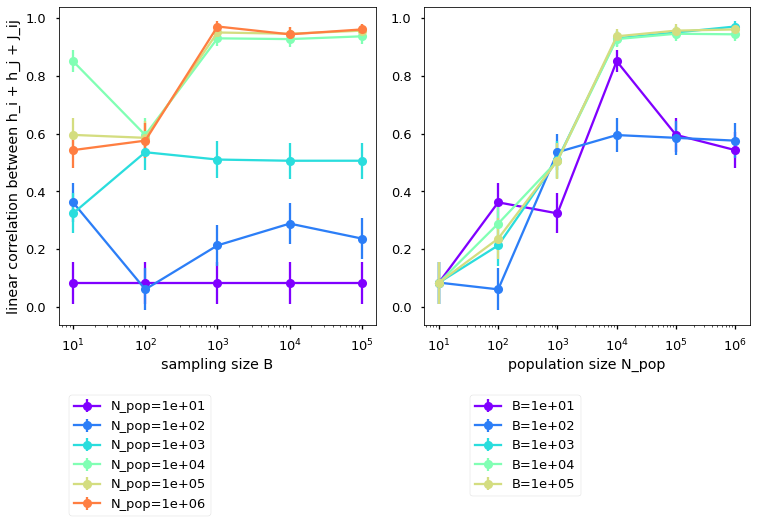

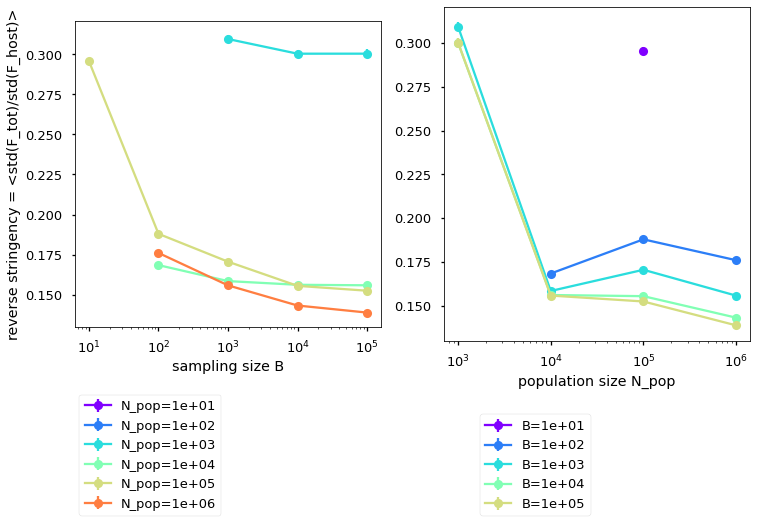

In [12]:
# load analysis results and make plots

simu_name = '2021Apr07'

result_directory = ('C:/Users/julia/Documents/Resources/InfluenzaFitnessLandscape/NewApproachFromMarch2021/'
                    'InfluenzaFitnessInference')
result_directory = os.path.normpath(result_directory)
temp_folder = os.path.join(result_directory, 'results', 'simulations', simu_name + '_temp')


analysis_filename = 'analysis_2021Apr14.data'
analysis_filepath = os.path.join(temp_folder, analysis_filename)
with open(analysis_filepath, 'rb') as f:
    ana_dict = pickle.load(f)
simu_info_filepath = ana_dict['simu_info_filepath']
with open(simu_info_filepath, 'rb') as f:
    simu_dict = pickle.load(f)
    
summary_stats_all = ana_dict['summary_stats_all']
ana_param_dict = ana_dict['ana_param_dict']
varied_ana_params = ana_dict['varied_ana_params']
varied_simu_params = simu_dict['varied_simu_params']
ana_list = ana_dict['ana_list']
run_list = simu_dict['run_list']
exp_dict = simu_dict['exp_dict']
exp_ana_dict = ana_dict['exp_ana_dict']
print(exp_dict)
print(exp_ana_dict)

### plots
file_ext_length = len('.data')
plot_file_path = analysis_filepath[:-file_ext_length] + '_plot'

# plot one summary stat with standard error:

param_name = 'r_hJ'
r_hJ = summary_stats_all[param_name]
SE_r_hJ = summary_stats_all['SE_' + param_name]

r_hJ_arr = np.reshape(np.array(r_hJ), (len(ana_list), len(run_list)))
SE_r_hJ_arr = np.reshape(np.array(SE_r_hJ), (len(ana_list), len(run_list)))

# plot against the varied analysis param
this_plot_filepath = plot_file_path + param_name + '.png'

fig, ((ax1,ax2)) = plt.subplots(1, 2, constrained_layout=True)

num_colors = len(run_list)
cm = plt.get_cmap('rainbow')
colorlist=list(cm(1.*i/num_colors) for i in range(num_colors))
test_param_list = exp_ana_dict['B']
for runnum in run_list:
    # plot linear correlation against varied simu param for a specific set
    # of analysis params
    ax1.errorbar(test_param_list, r_hJ_arr[:, runnum], SE_r_hJ_arr[:, runnum], 
                 marker='o',linestyle='-',zorder=1, color=colorlist[runnum], label='N_pop=%.e' % exp_dict['N_pop'][runnum])
ax1.legend(bbox_to_anchor=(0.5, -0.2))
ax1.set_xlabel('sampling size B')
ax1.set_ylabel('linear correlation between h_i + h_j + J_ij')
ax1.set_xscale('log')
ax1.set_aspect(1/ax1.get_data_ratio())

# plot against the varied simu param

num_colors = len(run_list)
cm = plt.get_cmap('rainbow')
colorlist=list(cm(1.*i/num_colors) for i in range(num_colors))
test_param_list = exp_dict['N_pop']
for ananum in ana_list:
    # plot linear correlation against varied simu param for a specific set
    # of analysis params
    ax2.errorbar(test_param_list, r_hJ_arr[ananum, :], SE_r_hJ_arr[ananum, :], 
                 marker='o',linestyle='-',zorder=1, color=colorlist[ananum], label='B=%.e' % exp_ana_dict['B'][ananum])
ax2.legend(bbox_to_anchor=(0.5, -0.2))
ax2.set_xlabel('population size N_pop')
# ax2.set_ylabel('linear correlation between h_i + h_j + J_ij')
ax2.set_xscale('log')

plt.savefig(this_plot_filepath, bbox_inches='tight')
plt.show()
plt.close()

# plot another stat with standard error

param_name = 'mean_string'
param = summary_stats_all[param_name]
# SE_r_hJ = summary_stats_all['SE_' + param_name]
SE_param = summary_stats_all['SE_string']

param_arr = np.reshape(np.array(param), (len(ana_list), len(run_list)))
SE_param_arr = np.reshape(np.array(SE_param), (len(ana_list), len(run_list)))

# plot against the varied analysis param
this_plot_filepath = plot_file_path + param_name + '.png'

fig, ((ax1,ax2)) = plt.subplots(1, 2, constrained_layout=True)

num_colors = len(run_list)
cm = plt.get_cmap('rainbow')
colorlist=list(cm(1.*i/num_colors) for i in range(num_colors))
test_param_list = exp_ana_dict['B']
for runnum in run_list:
    # plot linear correlation against varied simu param for a specific set
    # of analysis params
    ax1.errorbar(test_param_list, param_arr[:, runnum], SE_param_arr[:, runnum], 
                 marker='o',linestyle='-',zorder=1, color=colorlist[runnum], label='N_pop=%.e' % exp_dict['N_pop'][runnum])
ax1.legend(bbox_to_anchor=(0.5, -0.2))
ax1.set_xlabel('sampling size B')
ax1.set_ylabel('reverse stringency = <std(F_tot)/std(F_host)>')
ax1.set_xscale('log')
ax1.set_aspect(1/ax1.get_data_ratio())

# plot against the varied simu param

num_colors = len(run_list)
cm = plt.get_cmap('rainbow')
colorlist=list(cm(1.*i/num_colors) for i in range(num_colors))
test_param_list = exp_dict['N_pop']
for ananum in ana_list:
    # plot linear correlation against varied simu param for a specific set
    # of analysis params
    ax2.errorbar(test_param_list, param_arr[ananum, :], SE_param_arr[ananum, :], 
                 marker='o',linestyle='-',zorder=1, color=colorlist[ananum], label='B=%.e' % exp_ana_dict['B'][ananum])
ax2.legend(bbox_to_anchor=(0.5, -0.2))
ax2.set_xlabel('population size N_pop')
# ax2.set_ylabel('linear correlation between h_i + h_j + J_ij')
ax2.set_xscale('log')

plt.savefig(this_plot_filepath, bbox_inches='tight')
plt.show()
plt.close()

In [ ]:
#######################################################################
# old analysis

In [ ]:
# # load data from file again

# result_directory = os.path.normpath(result_directory)
# ana_file = os.path.join(result_directory, 'results', 'simulations', 'ana' + simu_name + '.data') 

# with open(ana_file, 'rb') as f:
#     ana_dict = pickle.load(f)
    
# summary_stats_all = ana_dict['summary_stats_all']
# inf_dict = ana_dict['inf_dict']
# exp_dict = inf_dict['exp_dict']


# ind_0 = 0
# r_hJ = summary_stats_all['r_hJ'][ind_0:]
# SE_r_hJ = summary_stats_all['SE_r_hJ'][ind_0:]
# N_pop_list = exp_dict['N_pop']

# # plot r_hJ +- SE_r_hJ
# fig = plt.figure()
# plt.errorbar(N_pop_list, r_hJ, SE_r_hJ, marker='o',linestyle='none',zorder=1)
# plt.xscale('log')
# plt.show()
# plt.close()

In [ ]:
# # sampling and inference parameters
# exp_dict = {'N_pop' : [10, 100, 10**3, 10**4, 10**5, 10**6]}

# result_directory = ('C:/Users/julia/Documents/Resources/InfluenzaFitnessLandscape/NewApproachFromMarch2021/'
#                     'InfluenzaFitnessInference')
# simu_name = '2021Apr07'
# single_simu_filename =\
# 'running_N_pop_1e+04N_site_20N_state_2mu_1e-04sigma_h_1D0_5h_0_-7J_0_0seed_123456N_simu_2e+02.data'
# exp_idx = 3

# # number of sequences sampled from surviving strains
# B = 10**3 
# # RNG seed for sampling
# seed = 20390 
# # generations to start and end inference
# inf_start = 100 
# inf_end = 200
# # regularization coefficients for the three types of inferred parameters
# # 0 means no regularization, 1 means unit variance
# lambda_h = 0
# lambda_J = 1
# lambda_f = 0

# inf_dict ={'simu_name': simu_name, 
#                'exp_dict': exp_dict, 
#                'seed': seed, 
#                'B': B, 
#                'inf_start': inf_start, 
#                'inf_end': inf_end, 
#                'lambda_h': lambda_h, 
#                'lambda_J': lambda_J, 
#                'lambda_f': lambda_f}

# # # run full analysis for a single simulation:

# # summary_stats = ana.single_simu_analysis(single_simu_filename, simu_name, exp_idx,
# #                                          seed, B, inf_start, inf_end, lambda_h, lambda_J, lambda_f,
# #                                          result_directory='C:/Users/julia/Documents/Resources/InfluenzaFitnessLandscape/'
# #                                     'NewApproachFromMarch2021/InfluenzaFitnessInference')

In [ ]:
# strain_yearly, strain_frequency_yearly, traj2 = ana.load_simu_data(single_simu_filename, simu_name, exp_idx)

# traj2.v_idx = 2
# # traj2.f_add_result('summary_stats', summary_stats,
# #                       comment='summary statistics')
# print(traj2.N_pop)

In [ ]:
# strain_yearly, strain_frequency_yearly, traj =\
#         ana.load_simu_data(single_simu_filename, simu_name, exp_idx, result_directory=result_directory)

# # model fitness landscape
# if traj.hJ_coeffs=='constant':
#     h_model, J_model = simu.fitness_coeff_constant(traj.N_site, traj.N_state, traj.h_0, traj.J_0)
# elif traj.hJ_coeffs=='p24':
#     h_model, J_model = simu.fitness_coeff_p24(traj.N_site, traj.N_state)

In [ ]:
# # strain_yearly = [strains.tolist() for strains in strain_yearly]
# print(strain_yearly[0])

In [ ]:
# # take random samples from each inference generation
# strain_sample_yearly, strain_sample_count_yearly, strain_sample_frequency_yearly=\
#     ana.sample_seqs(strain_yearly, strain_frequency_yearly, seed_sample, B, inf_end)

# # calculate -F_host for each time step between inf_start and inf_end
# minus_fhost_yearly = [-simu.fitness_host_list(strain_sample_yearly[t], strain_sample_yearly[:t], 
#                                               strain_sample_frequency_yearly[:t], traj.sigma_h, traj.D0)
#                     for t in range(inf_start, inf_end)]

# # calculate F_int for each time step between inf_start and inf_end
# fint_yearly = [simu.fitness_int_list(strain_sample_yearly[t], traj.N_state, h_model, J_model)
#                     for t in range(inf_start, inf_end)]

# # F_tot= F_int + F_host for each time step between inf_start and inf_end
# ftot_yearly = [[fint_yearly[t][i] - minus_fhost_yearly[t][i] for i in range(len(minus_fhost_yearly[t]))] 
#                for t in range(len(minus_fhost_yearly))]

In [ ]:
# # process data for inference (calculation of feature matrix X and output matrix Y)

# # calculation of features matrix X
# X = ana.inference_features_Ising(strain_sample_yearly[inf_start:inf_end])

# # calculation of response vector Y
# Y = ana.inference_response_FhostPrediction(minus_fhost_yearly)

# # inference (parameter vector M and standard error M_std of inferred params):
# M, M_std = ana.infer_ridge(X, Y, lambda_h, lambda_J, lambda_f, inf_start, inf_end)

In [ ]:
# mean std of fitnesses:

f_host_std = np.mean([np.std(fs) for fs in minus_fhost_yearly])
f_int_std = np.mean([np.std(fs) for fs in fint_yearly])
f_tot_std = np.mean([np.std(fs) for fs in ftot_yearly])
stringency = np.mean([(np.std(ftot)/np.std(mfhost)) for mfhost, ftot in zip(minus_fhost_yearly, ftot_yearly)])
SE_string = np.std([(np.std(ftot)/np.std(mfhost)) for mfhost, ftot in zip(minus_fhost_yearly, ftot_yearly)])/len(ftot_yearly)
print('mean std of F_host: ', f_host_std)
print('mean std of F_int: ', f_int_std)
print('mean std of F_tot: ', f_tot_std)
print('selection stringency: ', stringency, ' standard error: ', SE_string)

In [ ]:
# compare model fitness coeffs against inferred coeffs

# model coefficients
h_model_list, J_model_list, hJ_model_list = ana.hJ_model_lists(h_model, J_model)
# inferred coefficients
h_inf_list, J_inf_list, hJ_inf_list = ana.hJ_inf_lists(M, traj.N_site)
# std of inferred coefficients
std_h_inf_list, std_J_inf_list, std_hJ_inf_list = ana.hJ_inf_std_lists(M_std, traj.N_site)

r_h, pr_h=scipy.stats.pearsonr(h_model_list, h_inf_list) # pearson correlation
print('linear correlation for h: rho=',r_h,', p=',pr_h)
r_J, pr_J=scipy.stats.pearsonr(J_model_list, J_inf_list) 
print('linear correlation for J: rho=',r_J,', p=',pr_J)
r_hJ, pr_hJ=scipy.stats.pearsonr(hJ_model_list, hJ_inf_list) 
print('linear correlation for hi+hj+Jij: rho=',r_hJ,', p=',pr_hJ)

rho_h, prho_h=scipy.stats.spearmanr(h_model_list,h_inf_list) # spearman rank correlation
print('Spearman rank correlation for h: rho=',rho_h,', p=',prho_h)
rho_J, prho_J=scipy.stats.spearmanr(J_model_list,J_inf_list) # spearman rank correlation
print('Spearman rank correlation for J: rho=',rho_J,', p=',prho_J)
rho_hJ, prho_hJ=scipy.stats.spearmanr(hJ_model_list,hJ_inf_list) # spearman rank correlation
print('Spearman rank correlation for hi+hj+Jij: rho=',rho_hJ,', p=',prho_hJ)

In [ ]:
N_site = traj.N_site

h_epi_model,J_epi_model,hJ_epi_model=hJ_redlist_fromlist(h_model, J_model, N_site, 0) # model params
h_epi_inf,J_epi_inf,hJ_epi_inf,f_inf=coeffs_inf_reduced(M,inf_start,inf_end,N_site,0) # inferred params
h_epi_std,J_epi_std,hJ_epi_std,f_std=coeffs_std_reduced(M_std,inf_start,inf_end,N_site,0)

## comparison of inferred and model coefficients in one figure with 3 panels:
fig, ((ax1,ax2,ax3)) = plt.subplots(1, 3, constrained_layout=True)
# subplot for h comparison
x=np.linspace(-10,2,num=2)
fig=plt.figure()
ax1.errorbar(h_epi_model,h_epi_inf,h_epi_std,marker='o',linestyle='none',zorder=1)
ax1.plot(x,x,'-',color='black')
ax1.set(xlabel='model h')
ax1.set(ylabel='inferred h')
ax1.set_aspect(1/ax1.get_data_ratio())
# subplot for J comparison
x=np.linspace(-2,3,num=2)
fig=plt.figure()
ax2.errorbar(J_epi_model,J_epi_inf,J_epi_std,marker='o',linestyle='none',zorder=1)
#plt.plot(J_model[1327],M[num_h+1327],marker='o',linestyle='none',color='yellow',zorder=2)
#plt.plot(J_model[113],M[num_h+113],marker='o',linestyle='none',color='red',zorder=2)
ax2.plot(x,x,'-',color='black')
ax2.set(xlabel='model J')
ax2.set(ylabel='inferred J')
ax2.set_aspect(1/ax2.get_data_ratio())
# subplot for hi+hj+Jij comparison
x=np.linspace(-15,5,num=2)
fig=plt.figure()
ax3.errorbar(hJ_epi_model,hJ_epi_inf,hJ_epi_std,marker='o',linestyle='none',zorder=1)
ax3.plot(x,x,'-',color='black')
ax3.set(xlabel='model hi+hj+Jij')
ax3.set(ylabel='inferred hi+hj+Jij')
ax3.set_aspect(1/ax3.get_data_ratio())

# # plot for f(t):
# fig=plt.figure()
# plt.errorbar(np.arange(len(f_inf)),f_inf,f_std,marker='o',linestyle='none',zorder=1)
# plt.xlabel('inference generation')
# plt.ylabel('inferred f(t)')
# plt.show()
# plt.close()


rho, pval=scipy.stats.pearsonr(h_epi_model.flatten(),h_epi_inf) # spearman rank correlation
print('linear correlation for h: rho=',rho,', p=',pval)
rho, pval=scipy.stats.pearsonr(np.array(J_epi_model).flatten(),J_epi_inf) # spearman rank correlation
print('linear correlation for J: rho=',rho,', p=',pval)
rho, pval=scipy.stats.pearsonr(np.array(hJ_epi_model).flatten(),hJ_epi_inf) # spearman rank correlation
print('linear correlation for hi+hj+Jij: rho=',rho,', p=',pval)

print('\n')

rho, pval=scipy.stats.spearmanr(h_epi_model,h_epi_inf) # spearman rank correlation
print('Spearman rank correlation for h: rho=',rho,', p=',pval)
rho, pval=scipy.stats.spearmanr(np.array(J_epi_model).flatten(),J_epi_inf) # spearman rank correlation
print('Spearman rank correlation for J: rho=',rho,', p=',pval)
rho, pval=scipy.stats.spearmanr(np.array(hJ_epi_model).flatten(),hJ_epi_inf) # spearman rank correlation
print('Spearman rank correlation for hi+hj+Jij: rho=',rho,', p=',pval)

In [ ]:
# plot the data and fitnesses 
cm = plt.get_cmap('rainbow')
colorlist=list(cm(1.*i/(len(minus_fhost_yearly))) for i in range(len(minus_fhost_yearly)))

# -F_host
figure=plt.figure()
for t in range(len(minus_fhost_yearly)):
    plt.plot([t]*len(minus_fhost_yearly[t]), minus_fhost_yearly[t],'.',color=colorlist[t])
plt.xlabel('time step t')
plt.ylabel('-F_host(S,t)')
#plt.ylim([-10,60])
plt.show()
plt.close()

# F_int
figure=plt.figure()
for t in range(len(fint_yearly)):
    plt.plot([t]*len(fint_yearly[t]), fint_yearly[t],'.',color=colorlist[t])
plt.xlabel('time step t')
plt.ylabel('F_int(S,t)')
#plt.ylim([-10,60])
plt.show()
plt.close()

ftot_yearly = [[fint_yearly[t][i] - minus_fhost_yearly[t][i] for i in range(len(minus_fhost_yearly[t]))] 
               for t in range(len(minus_fhost_yearly))]
# F_tot
figure=plt.figure()
for t in range(len(fint_yearly)):
    plt.plot([t]*len(ftot_yearly[t]), ftot_yearly[t],'.',color=colorlist[t])
plt.xlabel('time step t')
plt.ylabel('F_int(S,t)')
#plt.ylim([-10,60])
plt.show()
plt.close()

# mean std of fitnesses:
f_host_std = np.mean([np.std(fs) for fs in minus_fhost_yearly])
f_int_std = np.mean([np.std(fs) for fs in fint_yearly])
f_tot_std = np.mean([np.std(fs) for fs in ftot_yearly])
print('mean std of F_host: ', f_host_std)
print('mean std of F_int: ', f_int_std)
print('mean std of F_tot: ', f_tot_std)